In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F_OLD
import torch as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, to_onehot
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:


lr = 0.0001
prior_size = 10
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, prior_size)).repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

In [6]:
data, label = next(iter(train_loader))

In [7]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [8]:
Enc = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
Dec = FullyConnected([prior_size+10, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)
Disc = FullyConnected([prior_size+10, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

In [9]:
# load pretrained checkpoints
checkpointEnc = torch.load('Enc_caae.pth.tar')
checkpointDec = torch.load('Dec_caae.pth.tar')
checkpointDisc = torch.load('Disc_caae.pth.tar')

In [10]:
#load pretrained weights
Enc.load_state_dict(checkpointEnc['state_dict'])
Enc_optimizer.load_state_dict(checkpointEnc['optimizer'])

Dec.load_state_dict(checkpointDec['state_dict'])
Dec_optimizer.load_state_dict(checkpointDec['optimizer'])

Disc.load_state_dict(checkpointDisc['state_dict'])
Disc_optimizer.load_state_dict(checkpointDisc['optimizer'])



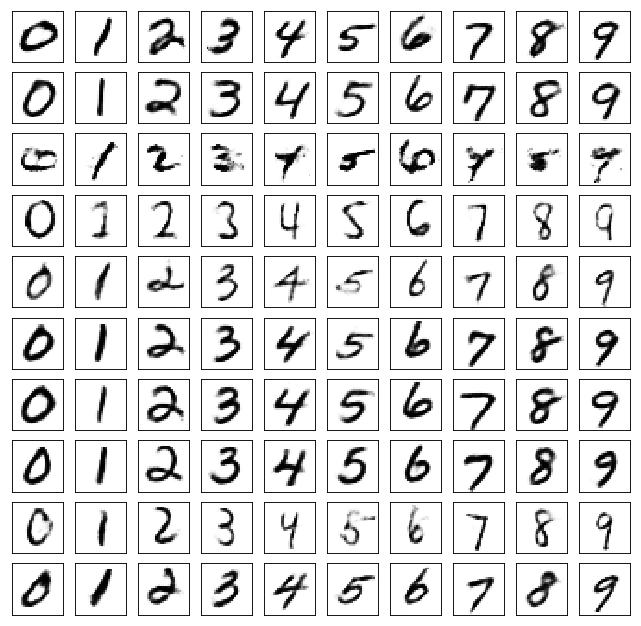

In [11]:
with torch.no_grad():
    fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
    plot_mnist(fixed_gen, (10, 10))

In [12]:
loader = train_loader
with torch.no_grad():
    data, target = next(iter(loader))
    data = Enc(data.to(device))
    print (data.shape)
    print (data)


torch.Size([250, 10])
tensor([[ 0.7769, -1.3704,  0.1674,  ...,  0.2450, -0.8067,  1.1208],
        [-1.6975,  0.9555, -0.5821,  ..., -0.9094, -0.5820, -0.4114],
        [ 0.2928, -1.0823,  0.0567,  ..., -1.6089,  0.2740, -1.2374],
        ...,
        [-0.9313, -0.3489, -1.4009,  ..., -0.1177,  1.5756,  0.9543],
        [-0.1285,  0.8720,  1.0972,  ..., -1.3714, -0.4771,  0.1620],
        [-0.6788,  0.4833, -0.6787,  ...,  0.0902,  1.1587, -0.0819]],
       device='cuda:0')


In [13]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1.1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        self.dropout = dropout
        self.to(device)
        
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 10)
        x = F.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.tanh(self.fc2(x))
        if self.dropout:
            x = F_OLD.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F_OLD.nll_loss(output, target, **kwargs)
        return self._loss

In [14]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        with torch.no_grad():
            data = Enc(data)
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target.to(device))
            loss.backward()
            model.optim.step()
            
    if batch_idx % 200 == 0:
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)



In [15]:
models = {'both': Net(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [16]:
def test(models, loader, log=None, name='Test'):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            data = Enc(data)
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target.to(device), reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.to(device).data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = f'{name} set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [17]:
for epoch in range(1, 301):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)
    test(models, train_loader, train_log, name='Train')

Train Epoch: 1 [50000/50000 (100%)]	Losses both: 2.294614
Test set:
both: Loss: 2.2974	Accuracy: 1298/10000 (12%)

Train set:
both: Loss: 2.2988	Accuracy: 6502/50000 (13%)

Train Epoch: 2 [50000/50000 (100%)]	Losses both: 2.284062
Test set:
both: Loss: 2.2905	Accuracy: 1374/10000 (13%)

Train set:
both: Loss: 2.2925	Accuracy: 6797/50000 (13%)

Train Epoch: 3 [50000/50000 (100%)]	Losses both: 2.298309
Test set:
both: Loss: 2.2895	Accuracy: 1384/10000 (13%)

Train set:
both: Loss: 2.2892	Accuracy: 6779/50000 (13%)

Train Epoch: 4 [50000/50000 (100%)]	Losses both: 2.285854
Test set:
both: Loss: 2.2882	Accuracy: 1363/10000 (13%)

Train set:
both: Loss: 2.2894	Accuracy: 6739/50000 (13%)

Train Epoch: 5 [50000/50000 (100%)]	Losses both: 2.285267
Test set:
both: Loss: 2.2904	Accuracy: 1388/10000 (13%)

Train set:
both: Loss: 2.2869	Accuracy: 6814/50000 (13%)

Train Epoch: 6 [50000/50000 (100%)]	Losses both: 2.282343
Test set:
both: Loss: 2.2883	Accuracy: 1399/10000 (13%)

Train set:
both: Los

Test set:
both: Loss: 2.2718	Accuracy: 1453/10000 (14%)

Train set:
both: Loss: 2.2707	Accuracy: 7359/50000 (14%)

Train Epoch: 49 [50000/50000 (100%)]	Losses both: 2.255323
Test set:
both: Loss: 2.2718	Accuracy: 1443/10000 (14%)

Train set:
both: Loss: 2.2698	Accuracy: 7431/50000 (14%)

Train Epoch: 50 [50000/50000 (100%)]	Losses both: 2.255624
Test set:
both: Loss: 2.2716	Accuracy: 1432/10000 (14%)

Train set:
both: Loss: 2.2702	Accuracy: 7370/50000 (14%)

Train Epoch: 51 [50000/50000 (100%)]	Losses both: 2.264010
Test set:
both: Loss: 2.2711	Accuracy: 1473/10000 (14%)

Train set:
both: Loss: 2.2702	Accuracy: 7407/50000 (14%)

Train Epoch: 52 [50000/50000 (100%)]	Losses both: 2.275417
Test set:
both: Loss: 2.2725	Accuracy: 1464/10000 (14%)

Train set:
both: Loss: 2.2695	Accuracy: 7416/50000 (14%)

Train Epoch: 53 [50000/50000 (100%)]	Losses both: 2.233143
Test set:
both: Loss: 2.2717	Accuracy: 1458/10000 (14%)

Train set:
both: Loss: 2.2696	Accuracy: 7403/50000 (14%)

Train Epoch: 54

Train set:
both: Loss: 2.2644	Accuracy: 7619/50000 (15%)

Train Epoch: 96 [50000/50000 (100%)]	Losses both: 2.266110
Test set:
both: Loss: 2.2693	Accuracy: 1467/10000 (14%)

Train set:
both: Loss: 2.2645	Accuracy: 7664/50000 (15%)

Train Epoch: 97 [50000/50000 (100%)]	Losses both: 2.271638
Test set:
both: Loss: 2.2690	Accuracy: 1463/10000 (14%)

Train set:
both: Loss: 2.2641	Accuracy: 7566/50000 (15%)

Train Epoch: 98 [50000/50000 (100%)]	Losses both: 2.289784
Test set:
both: Loss: 2.2695	Accuracy: 1432/10000 (14%)

Train set:
both: Loss: 2.2637	Accuracy: 7612/50000 (15%)

Train Epoch: 99 [50000/50000 (100%)]	Losses both: 2.241018
Test set:
both: Loss: 2.2697	Accuracy: 1450/10000 (14%)

Train set:
both: Loss: 2.2638	Accuracy: 7628/50000 (15%)

Train Epoch: 100 [50000/50000 (100%)]	Losses both: 2.237730
Test set:
both: Loss: 2.2694	Accuracy: 1474/10000 (14%)

Train set:
both: Loss: 2.2641	Accuracy: 7660/50000 (15%)

Train Epoch: 101 [50000/50000 (100%)]	Losses both: 2.270109
Test set:
b

Train set:
both: Loss: 2.2600	Accuracy: 7789/50000 (15%)

Train Epoch: 143 [50000/50000 (100%)]	Losses both: 2.277382
Test set:
both: Loss: 2.2697	Accuracy: 1458/10000 (14%)

Train set:
both: Loss: 2.2602	Accuracy: 7744/50000 (15%)

Train Epoch: 144 [50000/50000 (100%)]	Losses both: 2.247094
Test set:
both: Loss: 2.2708	Accuracy: 1445/10000 (14%)

Train set:
both: Loss: 2.2606	Accuracy: 7732/50000 (15%)

Train Epoch: 145 [50000/50000 (100%)]	Losses both: 2.262195
Test set:
both: Loss: 2.2700	Accuracy: 1420/10000 (14%)

Train set:
both: Loss: 2.2603	Accuracy: 7764/50000 (15%)

Train Epoch: 146 [50000/50000 (100%)]	Losses both: 2.287536
Test set:
both: Loss: 2.2695	Accuracy: 1476/10000 (14%)

Train set:
both: Loss: 2.2601	Accuracy: 7783/50000 (15%)

Train Epoch: 147 [50000/50000 (100%)]	Losses both: 2.236350
Test set:
both: Loss: 2.2684	Accuracy: 1494/10000 (14%)

Train set:
both: Loss: 2.2599	Accuracy: 7715/50000 (15%)

Train Epoch: 148 [50000/50000 (100%)]	Losses both: 2.275836
Test se

Train set:
both: Loss: 2.2565	Accuracy: 7804/50000 (15%)

Train Epoch: 190 [50000/50000 (100%)]	Losses both: 2.273771
Test set:
both: Loss: 2.2703	Accuracy: 1449/10000 (14%)

Train set:
both: Loss: 2.2572	Accuracy: 7885/50000 (15%)

Train Epoch: 191 [50000/50000 (100%)]	Losses both: 2.241655
Test set:
both: Loss: 2.2702	Accuracy: 1436/10000 (14%)

Train set:
both: Loss: 2.2568	Accuracy: 7876/50000 (15%)

Train Epoch: 192 [50000/50000 (100%)]	Losses both: 2.252187
Test set:
both: Loss: 2.2696	Accuracy: 1476/10000 (14%)

Train set:
both: Loss: 2.2567	Accuracy: 7803/50000 (15%)

Train Epoch: 193 [50000/50000 (100%)]	Losses both: 2.283540
Test set:
both: Loss: 2.2701	Accuracy: 1471/10000 (14%)

Train set:
both: Loss: 2.2558	Accuracy: 7885/50000 (15%)

Train Epoch: 194 [50000/50000 (100%)]	Losses both: 2.261320
Test set:
both: Loss: 2.2689	Accuracy: 1479/10000 (14%)

Train set:
both: Loss: 2.2570	Accuracy: 7807/50000 (15%)

Train Epoch: 195 [50000/50000 (100%)]	Losses both: 2.231305
Test se

Train set:
both: Loss: 2.2538	Accuracy: 8057/50000 (16%)

Train Epoch: 237 [50000/50000 (100%)]	Losses both: 2.250640
Test set:
both: Loss: 2.2716	Accuracy: 1431/10000 (14%)

Train set:
both: Loss: 2.2535	Accuracy: 7994/50000 (15%)

Train Epoch: 238 [50000/50000 (100%)]	Losses both: 2.236777
Test set:
both: Loss: 2.2704	Accuracy: 1472/10000 (14%)

Train set:
both: Loss: 2.2539	Accuracy: 7965/50000 (15%)

Train Epoch: 239 [50000/50000 (100%)]	Losses both: 2.244996
Test set:
both: Loss: 2.2704	Accuracy: 1466/10000 (14%)

Train set:
both: Loss: 2.2532	Accuracy: 8022/50000 (16%)

Train Epoch: 240 [50000/50000 (100%)]	Losses both: 2.278200
Test set:
both: Loss: 2.2701	Accuracy: 1481/10000 (14%)

Train set:
both: Loss: 2.2530	Accuracy: 8001/50000 (16%)

Train Epoch: 241 [50000/50000 (100%)]	Losses both: 2.264554
Test set:
both: Loss: 2.2698	Accuracy: 1429/10000 (14%)

Train set:
both: Loss: 2.2536	Accuracy: 7917/50000 (15%)

Train Epoch: 242 [50000/50000 (100%)]	Losses both: 2.262174
Test se

Train set:
both: Loss: 2.2513	Accuracy: 8096/50000 (16%)

Train Epoch: 284 [50000/50000 (100%)]	Losses both: 2.233182
Test set:
both: Loss: 2.2720	Accuracy: 1432/10000 (14%)

Train set:
both: Loss: 2.2512	Accuracy: 8118/50000 (16%)

Train Epoch: 285 [50000/50000 (100%)]	Losses both: 2.236505
Test set:
both: Loss: 2.2703	Accuracy: 1480/10000 (14%)

Train set:
both: Loss: 2.2516	Accuracy: 8067/50000 (16%)

Train Epoch: 286 [50000/50000 (100%)]	Losses both: 2.241648
Test set:
both: Loss: 2.2703	Accuracy: 1484/10000 (14%)

Train set:
both: Loss: 2.2514	Accuracy: 8032/50000 (16%)

Train Epoch: 287 [50000/50000 (100%)]	Losses both: 2.255441
Test set:
both: Loss: 2.2702	Accuracy: 1487/10000 (14%)

Train set:
both: Loss: 2.2510	Accuracy: 8096/50000 (16%)

Train Epoch: 288 [50000/50000 (100%)]	Losses both: 2.259549
Test set:
both: Loss: 2.2714	Accuracy: 1445/10000 (14%)

Train set:
both: Loss: 2.2512	Accuracy: 8087/50000 (16%)

Train Epoch: 289 [50000/50000 (100%)]	Losses both: 2.238948
Test se

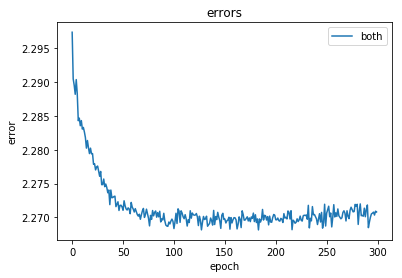

In [18]:
# Проверка "Честного" автокодировщика
# На выходе енкодера признаки метки стираются, поэтому нельзя извлечь эту информацию
# угадывание на уровне случайного
plot_graphs(test_log, 'loss')

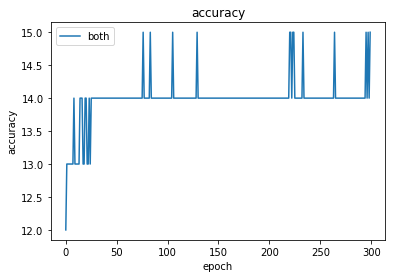

In [19]:
plot_graphs(test_log, 'accuracy')

In [20]:
# Дополнительное задание взять стиль у цифры и распечатать остальные с таким же стилем
train_loader, valid_loader, test_loader = mnist(batch_size=50, valid=10000, transform=mnist_tanh)
data, target = next(iter(test_loader))

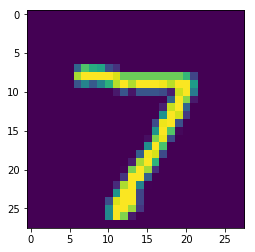

In [21]:
plt.imshow(data[0][0].cpu())

In [22]:
data[0][0].shape

torch.Size([28, 28])

In [23]:
with torch.no_grad():
    latent = Enc(data[0][0].view(1, 28*28))

In [24]:
latent

tensor([[ 0.5987,  0.3122,  0.9331, -0.0478, -0.6051, -0.6362,  2.1025, -0.2595,
          1.4954,  0.4255]], device='cuda:0')

In [25]:
fixed_z = latent.repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((1)), 10).to(device)

In [26]:
with torch.no_grad():
    fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy()

In [27]:
fixed_z.shape

torch.Size([10, 10])

In [28]:
fixed_z_label.shape

torch.Size([10, 10])

In [29]:
fixed_gen.reshape(10, 1, 28, 28).shape

(10, 1, 28, 28)

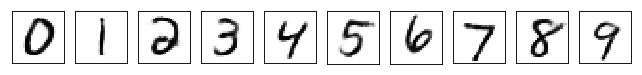

In [30]:
plot_mnist(fixed_gen.reshape(10, 1, 28, 28), (1, 10))

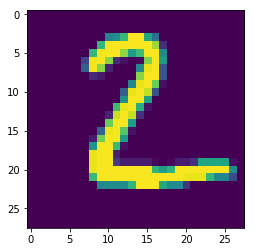

In [31]:
plt.imshow(data[1][0].cpu())

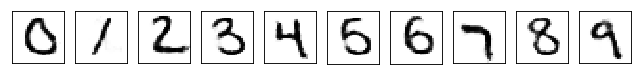

In [32]:
with torch.no_grad():
    latent = Enc(data[1][0].view(1, 28*28))
    fixed_z = latent.repeat((1,10)).view(-1, prior_size).to(device)
    fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((1)), 10).to(device)
    fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy()
    plot_mnist(fixed_gen.reshape(10, 1, 28, 28), (1, 10))

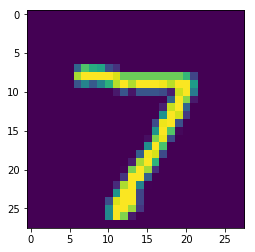

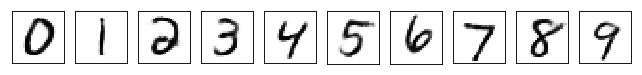

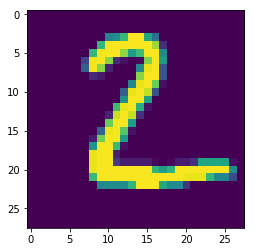

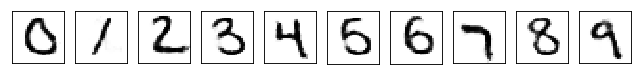

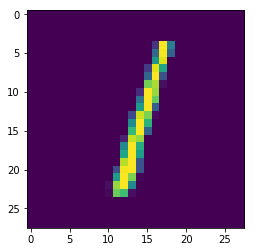

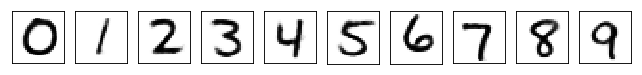

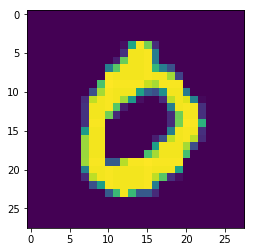

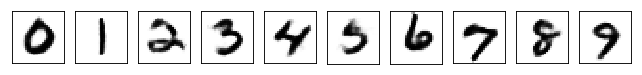

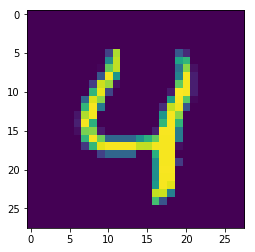

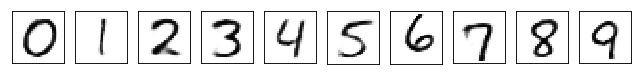

In [33]:
for item in range(5):
    with torch.no_grad():
        plt.imshow(data[item][0].cpu())
        latent = Enc(data[item][0].view(1, 28*28))
        fixed_z = latent.repeat((1,10)).view(-1, prior_size).to(device)
        fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((1)), 10).to(device)
        fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy()
        plot_mnist(fixed_gen.reshape(10, 1, 28, 28), (1, 10))
